<a href="https://colab.research.google.com/github/ssaran2014/tensorflow/blob/master/beans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tensorflow Beans Example**

This code demonstrates the use of Tensorflow to classify images of bean leaves.
https://www.tensorflow.org/datasets/catalog/beans 

The original machine learning challenge is described here:
https://github.com/AI-Lab-Makerere/ibean/

The first set of three cells below are optional. They are just being used to make sure that the GPU is turned on in the Google Colab. Thank you Google for making such an amazing resource available for free.


In [ ]:
#confirm that Google Colabs GPU is turned on
#' ' means CPU whereas '/device:G:0' means GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#run this procedure if much of the GPU RAM is being used up
#the cell below can be used to see how much of the RAM is being used
#!kill -9 -1

In [ ]:
#procedure to see how much of the RAM is being used
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=013fcb444f7cbb8f5c125edb800ddf5b6f9bebd4621d29b3049d6c6029695c2c
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.2 GB  | Proc size: 1.1 GB
GPU RAM Free: 15927MB | Used: 353MB | Util   2% | Total 16280MB


In [ ]:
#import utils to save data on the disk
import pathlib
import os

# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_datasets.public_api as tfds
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

print(tf.__version__)

2.2.0


In [ ]:
#Load data on to the disk. Put in a directory called 'train' and 'validation', respectively
#Test directory is downloaded later.
train_data = tf.keras.utils.get_file(origin="https://storage.googleapis.com/ibeans/train.zip", cache_subdir='datasets', fname='train_data', extract=True, cache_dir = 'train')

validation_data = tf.keras.utils.get_file(origin="https://storage.googleapis.com/ibeans/validation.zip", cache_subdir='datasets', fname='validation_data', extract=True, cache_dir = 'validation')

18505728/18504213 [==============================] - 1s 0us/step


In [ ]:
#confirm directory where the file is stored
print("Training data directory: ", train_data)
print("Validation data directory: ", validation_data)

Training data directory:  /tmp/.keras/datasets/train_data
Validation data directory:  /tmp/.keras/datasets/validation_data


In [ ]:
#see the contents of the train directory
#It should be three subdirectories; one for each class
class_names = os.listdir('/tmp/.keras/datasets/train')
print(class_names)

['angular_leaf_spot', 'bean_rust', 'healthy']


In [ ]:
#check the train paths and the number of files in each class
train_dir = '/tmp/.keras/datasets/train'
for class_name in class_names:
  print('total '+class_name+' training images:', len(os.listdir(os.path.join((train_dir), class_name ))))

total angular_leaf_spot training images: 345
total bean_rust training images: 348
total healthy training images: 342


In [ ]:
#check the vaidation paths and the number of files in each class
validation_dir = '/tmp/.keras/datasets/validation'
for class_name in class_names:
  print('total '+class_name+' validation images:', len(os.listdir(os.path.join((validation_dir), class_name ))))

total angular_leaf_spot validation images: 44
total bean_rust validation images: 45
total healthy validation images: 44


In [ ]:
#create training directory list
angular_leaf_spot_train_dir = os.path.join(train_dir, 'angular_leaf_spot')
bean_rust_train_dir = os.path.join(train_dir, 'bean_rust')
healthy_train_dir = os.path.join(train_dir, 'healthy')
train_directory_list = [angular_leaf_spot_train_dir, bean_rust_train_dir, healthy_train_dir]

<Figure size 432x288 with 0 Axes>

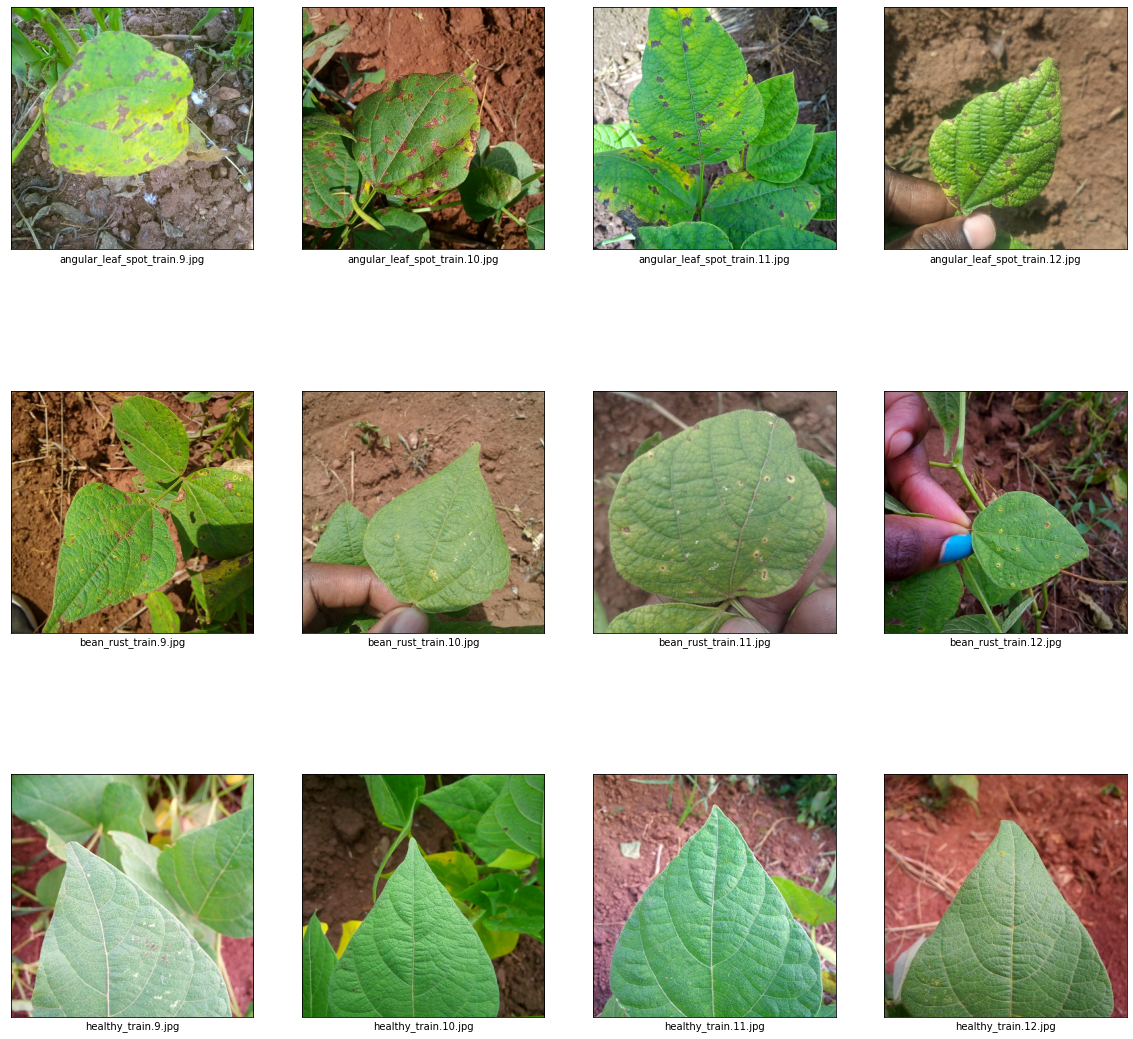

In [ ]:
#see pictures of each of the bean classes
#each row is a different class
#four pictures shown at one time

%matplotlib inline
import matplotlib.image as mpimg

nrows, ncols = 3, 4

fig = plt.gcf()
plt.subplots(nrows = 3, ncols = 4, figsize=(20,20))

counter = 1
for  j in range(3):
  class_name = class_names[j]
  directory = train_directory_list[j]
  for i in range(9, 13): #change range to show 4 different sets of images (0,5), (5,9) etc
    sp = plt.subplot(3, 4, counter)
    plt.rcParams["axes.grid"] = False
    file_path = directory+'/'+class_name+'_train.'+str(i)+'.jpg'
    file_name = class_name+'_train.'+str(i)+'.jpg'
    plt.xlabel(file_name)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img=mpimg.imread(file_path)
    plt.imshow(img)
    counter += 1
    
plt.show()

In [ ]:
#Uploading the full train and validation set will make the RAM run out of
#memory when the model is run. So images are streamed in batches.
#Images are also augmented to increase the size of the training set

#create streaming using the ImageGenerator function
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255, #rescaling to make each pixel between 0 and 1
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(500, 500), #picture size is 500px * 500px
        batch_size=32,
        class_mode='categorical')

validation_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode = 'nearest')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(500, 500),
        batch_size=20,
        class_mode='categorical')

Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


In [ ]:
#create the model
model = tf.keras.models.Sequential([
                                    #1st convolution layer
                                    tf.keras.layers.Conv2D(16, (3,3), input_shape=(500,500,3), activation = 'relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    #2nd convolution layer
                                    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    #3rd convolution layer
                                    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    #flattening and creating dense layers
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation = 'relu'),
                                    tf.keras.layers.Dense(512, activation = 'relu'),
                                    tf.keras.layers.Dense(3, activation = 'softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 498, 498, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 249, 249, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 247, 247, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 121, 121, 64)      18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 230400)           

In [ ]:
#compile the model
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
#loss and accuracy metrics are stored in history so that they can be plotted
#multiple different epochs were used. Epochs over 40 provide the best results.

history = model.fit_generator(train_generator,
                              epochs = 100,
                              verbose = 1,
                              validation_data = validation_generator)

Epoch 1/100
33/33 [==============================] - 66s 2s/step - loss: 0.2612 - accuracy: 0.8975 - val_loss: 0.2857 - val_accuracy: 0.8947
Epoch 2/100
33/33 [==============================] - 66s 2s/step - loss: 0.2090 - accuracy: 0.9236 - val_loss: 0.4226 - val_accuracy: 0.8271
Epoch 3/100
33/33 [==============================] - 66s 2s/step - loss: 0.3368 - accuracy: 0.8665 - val_loss: 0.2717 - val_accuracy: 0.9023
Epoch 4/100
33/33 [==============================] - 66s 2s/step - loss: 0.2553 - accuracy: 0.9062 - val_loss: 0.3249 - val_accuracy: 0.8722
Epoch 5/100
33/33 [==============================] - 65s 2s/step - loss: 0.1895 - accuracy: 0.9246 - val_loss: 0.3327 - val_accuracy: 0.9023
Epoch 6/100
33/33 [==============================] - 65s 2s/step - loss: 0.2561 - accuracy: 0.9052 - val_loss: 0.2819 - val_accuracy: 0.8647
Epoch 7/100
33/33 [==============================] - 66s 2s/step - loss: 0.2726 - accuracy: 0.8868 - val_loss: 0.3109 - val_accuracy: 0.8647
Epoch 8/100
3

Text(0.5, 1.0, 'Training and Validation Loss')

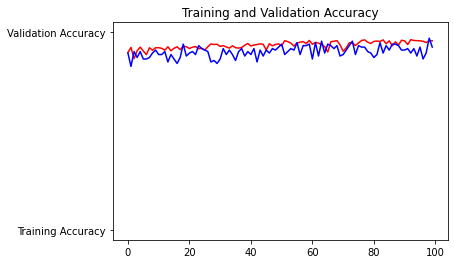

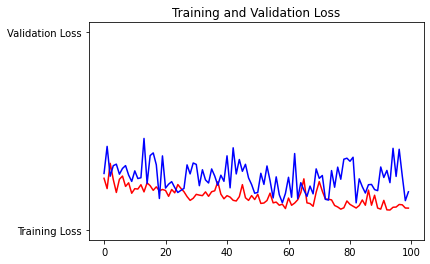

In [ ]:
#plotting the loss function and accuracy

#retrieving a list of list results on training and validation datasets for each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) #get number of epochs

#plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.figure()

#plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.title("Training and Validation Loss")


In [ ]:
#validation loss and accuracy with other hyperparameters are shown below.

#65/65 [==============================] - 66s 1s/step - loss: 0.5231 - accuracy: 0.7737 - val_loss: 0.5721 - val_accuracy: 0.7293
#train batch = 16; validation batch = 10, epochs = 20

#33/33 [==============================] - 63s 2s/step - loss: 0.5170 - accuracy: 0.7766 - val_loss: 0.5284 - val_accuracy: 0.7293
#train bath = 32; validation batch = 10,  epochs = 20

#33/33 [==============================] - 66s 2s/step - loss: 0.5430 - accuracy: 0.7727 - val_loss: 0.6200 - val_accuracy: 0.7218
#train batch = 32; validation batch = 20,  epochs = 20
#validation accuracy line is smoother. But there is barely any change in training accuracy or validation accuracy

#33/33 [==============================] - 64s 2s/step - loss: 0.2478 - accuracy: 0.8936 - val_loss: 0.3276 - val_accuracy: 0.8797
#train batch = 32; validation batch = 20,  epochs = 40
#significant improvement in acccuracy when epochs are increased to 40; the accuracy line also becomes smoother

#33/33 [==============================] - 66s 2s/step - loss: 0.1103 - accuracy: 0.9565 - val_loss: 0.1928 - val_accuracy: 0.9248
##train batch = 32; validation batch = 20,  epochs = 100
#accuracy increases with more epochs. Evidence of overfitting.

In [ ]:
#load the test data
test_data = tf.keras.utils.get_file(origin="https://storage.googleapis.com/ibeans/test.zip", cache_subdir='datasets', fname='test_data', extract=True, cache_dir = 'test')
print(test_data)

17711104/17708541 [==============================] - 1s 0us/step
/tmp/.keras/datasets/test_data


In [ ]:
#check the test paths and the number of files in each class
test_dir = '/tmp/.keras/datasets/test'
for class_name in class_names:
  print('total '+class_name+' validation images:', len(os.listdir(os.path.join((validation_dir), class_name ))))

total angular_leaf_spot validation images: 44
total bean_rust validation images: 45
total healthy validation images: 44


In [ ]:
#preparing the test images for streaming
#predicting results and storing them in the pred variable

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(500, 500),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)

test_generator.reset()
pred = model.predict(test_generator, verbose = 1, steps=128)

Found 128 images belonging to 3 classes.
128/128 [==============================] - 1s 9ms/step


In [ ]:
#forming a way to compare predictions to the actual
#storing results in a dataframe, so it can be downloaded easily

import pandas as pd

predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

In [ ]:

results.head

<bound method NDFrame.head of                                             Filename        Predictions
0     angular_leaf_spot/angular_leaf_spot_test.0.jpg  angular_leaf_spot
1     angular_leaf_spot/angular_leaf_spot_test.1.jpg  angular_leaf_spot
2    angular_leaf_spot/angular_leaf_spot_test.10.jpg  angular_leaf_spot
3    angular_leaf_spot/angular_leaf_spot_test.11.jpg  angular_leaf_spot
4    angular_leaf_spot/angular_leaf_spot_test.12.jpg  angular_leaf_spot
..                                               ...                ...
123                       healthy/healthy_test.5.jpg            healthy
124                       healthy/healthy_test.6.jpg            healthy
125                       healthy/healthy_test.7.jpg            healthy
126                       healthy/healthy_test.8.jpg            healthy
127                       healthy/healthy_test.9.jpg            healthy

[128 rows x 2 columns]>

In [ ]:
#downloading results
results.to_csv("results.csv", index=False)

This model had 95% accuracy on the test images.

Not bad. 

How can the model be improved?

In [ ]:
"""
The following code was used to create a learning rate optimizer.
The optimizer showed that the default learning rate being used by the 
Adam optimizer was the best one. Therefore, this code wasn't used.


#trying to use a learning rate optimizer

#create the model
model_lro = tf.keras.models.Sequential([
                                    #1st convolution layer
                                    tf.keras.layers.Conv2D(16, (3,3), input_shape=(500,500,3), activation = 'relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    #2nd convolution layer
                                    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    #3rd convolution layer
                                    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    #flattening and creating dense layers
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation = 'relu'),
                                    tf.keras.layers.Dense(512, activation = 'relu'),
                                    tf.keras.layers.Dense(3, activation = 'softmax')
])

model_lro.summary()

optimizer = tf.keras.optimizers.Adam(lr=1e-4)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20))

#compile the model
model_lro.compile(
    optimizer = optimizer,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

history_lro = model_lro.fit_generator(train_generator,
                              epochs = 40,
                              verbose = 1,
                              validation_data = validation_generator,
                              callbacks = [lr_schedule])
"""

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 498, 498, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 249, 249, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 247, 247, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 121, 121, 64)      18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 60, 60, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 230400)           

(0.0001, 0.01, 0.0, 1.5)

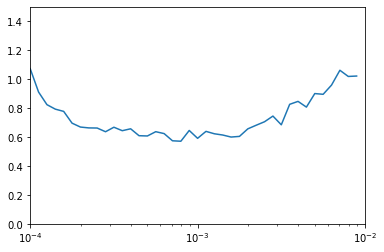

In [ ]:
"""
#figure out the best learning rate
plt.semilogx(history_lro.history["lr"], history_lro.history["loss"])
plt.axis([1e-4, 1e-2, 0, 1.5])
"""